In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.model_selection import StratifiedKFold
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
data=pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test_data=pd.read_csv("../input/contradictory-my-dear-watson/test.csv")


In [3]:
## check sentences with less than 5 characters

for i in range(len(data)):
    if len(data["premise"][i])<5 or len(data["hypothesis"][i])<5:
        print(data["premise"][i]+ ">>"+ data["hypothesis"][i])

彼此阻拦>>是的，阻碍彼此。
'Of course.'>>Yes.


In [4]:
## check max avg and min len of sentences
premise=[]
hypothesis=[]

for i in range(len(data)):
    premise.append(len(data["premise"][i]))
    hypothesis.append(len(data["hypothesis"][i]))
    
print("Average len of characters in premise",sum(premise)//len(premise))
print("Maximum len of characters in premise",max(premise))
print("Minimum len of characters in premise",min(premise),end="\n\n")

print("Average len of characters in hypothesis",sum(hypothesis)//len(hypothesis))
print("Maximum len of characters in hypothesis",max(hypothesis))
print("Minimum len of characters in hypothesis",min(hypothesis))



Average len of characters in premise 107
Maximum len of characters in premise 967
Minimum len of characters in premise 4

Average len of characters in hypothesis 53
Maximum len of characters in hypothesis 276
Minimum len of characters in hypothesis 4


In [5]:
language_data=pd.DataFrame(data["language"].value_counts()).reset_index().rename(columns={"index":"language","language":"counts"})

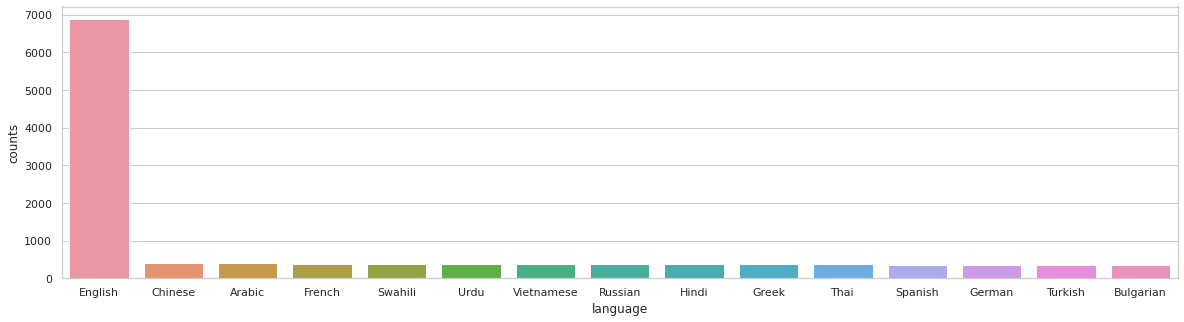

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(20,5))

sns.set(style="whitegrid")
ax = sns.barplot(x=language_data["language"], y=language_data["counts"])

In [7]:
languages4plot=[]
Percentage=[]
for ind in range(len(language_data)):
    Percentage.append(round((language_data["counts"][ind]/sum(language_data["counts"]))*100,2))
    languages4plot.append(language_data['language'][ind])
    

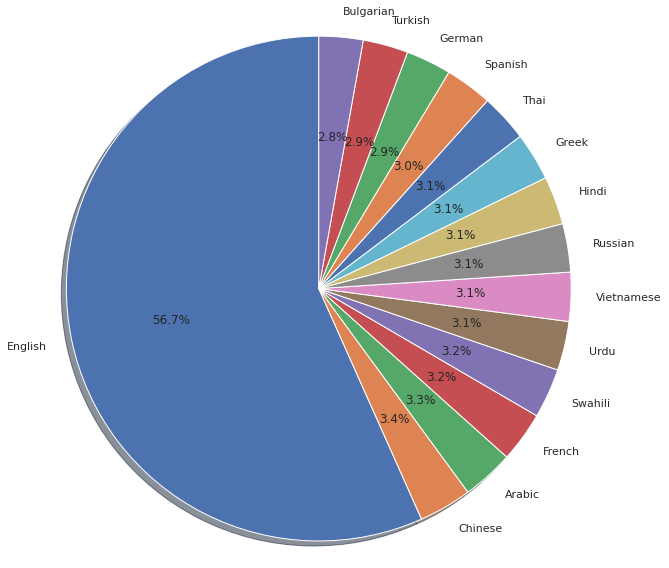

In [8]:
explode=np.random.uniform(0,0,len(Percentage))
plt.figure(figsize=(10,10))
plt.pie(Percentage, explode=explode, labels=languages4plot, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [9]:
from transformers import RobertaConfig, RobertaModel,RobertaTokenizer
from transformers import BertTokenizer, TFBertModel, AutoTokenizer, TFAutoModel

tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-uncased",do_lower_case=True)


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [10]:
tokenize_premise=[]
tokenize_hypothesis=[]
languages=[]

for ind in range(len(data)):
    tokenize_premise.append(len(list(tokenizer.tokenize(data["premise"][ind], return_tensors="tf"))))
    tokenize_hypothesis.append(len(list(tokenizer.tokenize(data["hypothesis"][ind], return_tensors="tf"))))
    languages.append(data["language"][ind])
    

In [11]:
print("Average len of premise",sum(tokenize_premise)//len(tokenize_premise))
print("Maximum len of premise",max(tokenize_premise))
print("Minimum len of premise",min(tokenize_premise),end="\n\n")

print("Average len of hypothesis",sum(tokenize_hypothesis)//len(tokenize_hypothesis))
print("Maximum len of hypothesis",max(tokenize_hypothesis))
print("Minimum len of hypothesis",min(tokenize_hypothesis))


Average len of premise 27
Maximum len of premise 226
Minimum len of premise 1

Average len of hypothesis 13
Maximum len of hypothesis 64
Minimum len of hypothesis 1


Here is the plot of average length of the Sentences according the the languages for premise column

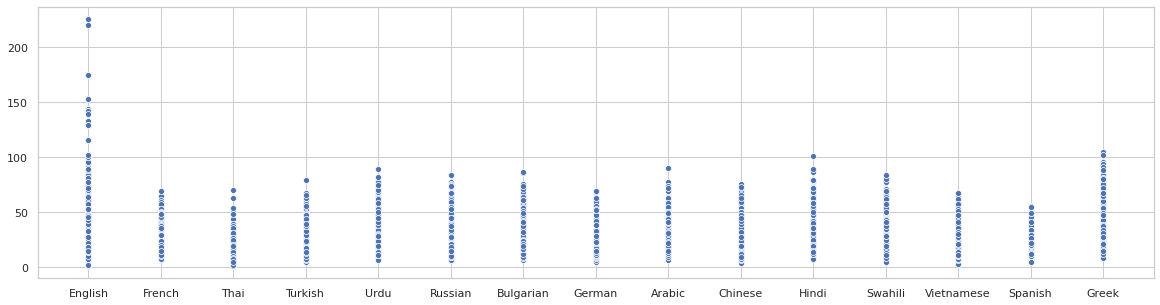

In [12]:
plt.figure(figsize=(20,5))

sns.set(style="whitegrid")
ax = sns.scatterplot(x=languages, y=tokenize_premise)

Average Sentence length for hypothesis

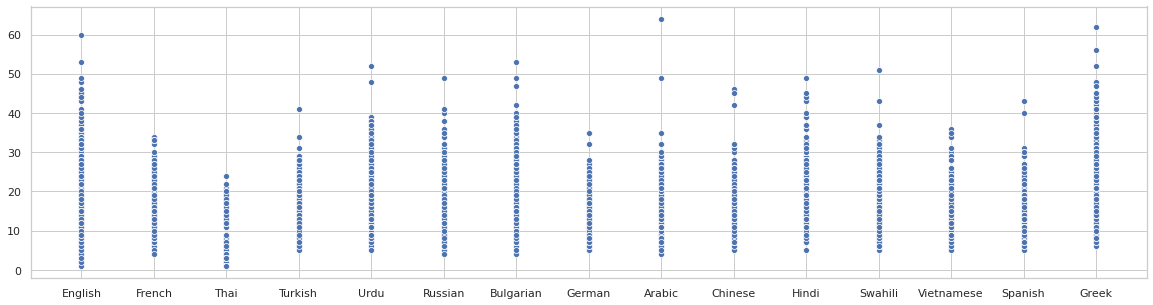

In [13]:
plt.figure(figsize=(20,5))

sns.set(style="whitegrid")
ax = sns.scatterplot(x=languages, y=tokenize_hypothesis)


In [14]:
def encode_sentence(s):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   token_ids=tokenizer.convert_tokens_to_ids(tokens)
   return token_ids

In [15]:
def bert_encode(hypotheses, premises, tokenizer):
    
  num_examples = len(hypotheses)
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s)
      for s in np.array(hypotheses)])
  sentence2 = tf.ragged.constant([
      encode_sentence(s)
       for s in np.array(premises)])
    
  

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [16]:
data=data.sample(frac=1).reset_index(drop=True)


In [17]:
X_data=data[["premise", "hypothesis"]]
Y_data=data["label"]

In [18]:
count_df=pd.DataFrame(Y_data.value_counts()).reset_index().rename(columns={"index":"label","label":"counts"})
labels=list(count_df["label"])
sizes=[(i/len(Y_data))*100 for i in count_df["counts"]]
explode = (0, 0.1, 0)

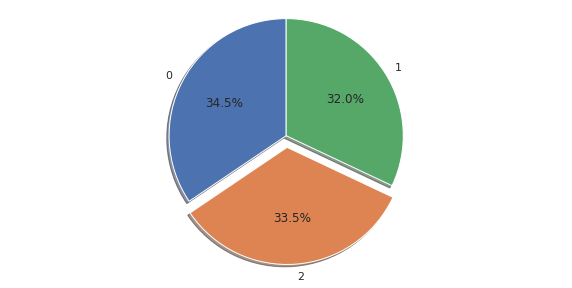

In [19]:
plt.figure(figsize=(10,5))
plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [20]:
tab_data=pd.get_dummies(data["language"]).values

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
skf = StratifiedKFold(n_splits=5)



In [22]:
import tensorflow as tf
inputs=bert_encode(data.hypothesis.values, data.premise.values, tokenizer)

In [23]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Number of replicas:', strategy.num_replicas_in_sync)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 8


In [39]:
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
import tensorflow_addons as tfa

max_len = 50

def build_model():
#     bert_encoder = TFAutoModel.from_pretrained("roberta-large-mnli")
    bert_encoder = TFBertModel.from_pretrained("bert-base-multilingual-uncased")
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    input_type_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_type_ids")
    
    for layer in bert_encoder.layers:
        layer.trainable=True
    
    
    
    
#     embedding = bert_encoder(input_word_ids)[0]
    embedding = bert_encoder([input_word_ids,input_mask,input_type_ids])[0]
    d1=tf.keras.layers.Dropout(0.1)(embedding[:,0,:])
#     first = tf.keras.layers.Dense(256, activation='relu')(embedding[:,0,:])
    
#     second = tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(embedding[:,0,:])
    

    output = tf.keras.layers.Dense(3, activation='softmax')(d1)
    
  

# ...

    optimizer = tf.optimizers.Adadelta(learning_rate=0.001)
    
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)
#     model = tf.keras.Model(inputs=input_word_ids, outputs=output)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

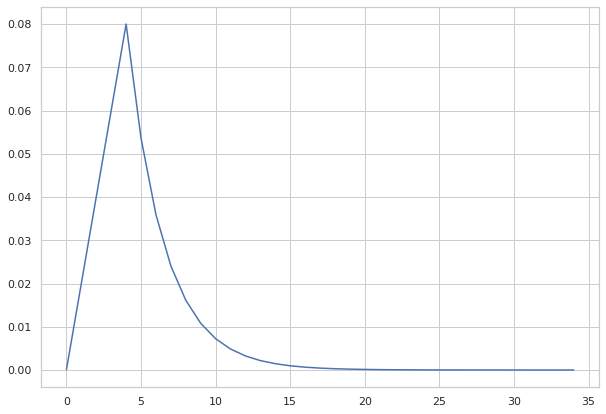

In [40]:
# CUSTOM LEARNING SCHEUDLE
import matplotlib.pyplot as plt


def build_lrfn(lr_start=0.0001, lr_max=0.001, 
               lr_min=0.00001, lr_rampup_epochs=4, 
               lr_sustain_epochs=0, lr_exp_decay=.87):
    lr_max = lr_max * strategy.num_replicas_in_sync

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay**(epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    
    return lrfn

plt.figure(figsize=(10, 7))

_lrfn = build_lrfn()
plt.plot([i for i in range(35)], [_lrfn(i) for i in range(35)]);

In [41]:
X_test=test_data
X_test=train_inputs=bert_encode(X_test.premise.values, X_test.hypothesis.values, tokenizer)

In [42]:
len(test_data)

5195

In [44]:
import tensorflow as tf
test_pred=np.zeros((len(test_data),3))

EPOCHS=10
a=0
score=[]
for train_index, test_index in skf.split(X_data, Y_data):
    tf.keras.backend.clear_session()
    
    with strategy.scope():
        model = build_model()
    
    print("",end="\n\n")
        
    print(f"Generating Inputs for fold {a}")
    
    print("=="*20)
    
    train_inputs=bert_encode(X_data.iloc[train_index].premise.values, X_data.iloc[train_index].hypothesis.values, tokenizer)
  
    
    train_labels=Y_data[train_index]
    
    val_inputs=bert_encode(X_data.iloc[test_index].premise.values, X_data.iloc[test_index].hypothesis.values, tokenizer)
    test_labels=Y_data[test_index]
    
    
    
    lr2 = tf.keras.callbacks.LearningRateScheduler(_lrfn, verbose = True)
    
    lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                            factor=0.8, 
                                            patience=2)
    early_stopping=tf.keras.callbacks.EarlyStopping(patience=10)
    model.fit(train_inputs, train_labels,epochs=50, verbose = 1,
              validation_data=(val_inputs,test_labels),
              batch_size = 128,callbacks=[early_stopping,lr2])
    results=model.evaluate(val_inputs,test_labels)
    print("====== predicting test===========")
    test_pred += model.predict(X_test)
    
  
    print("====== predicting test Done===========")
    print(f"score for fold {a} is",results[1])
    
    print("==="*20)
    score.append(results[1])
    
    a+=1
    
print("final LB score",np.mean(score))
    
    
       
    



Generating Inputs for fold 0

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/50
76/76 [==============================] - 62s 812ms/step - loss: 1.2016 - accuracy: 0.3190 - val_loss: 1.1797 - val_accuracy: 0.3189 - lr: 1.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.020075.
Epoch 2/50
76/76 [==============================] - 16s 213ms/step - loss: 1.1048 - accuracy: 0.3774 - val_loss: 1.0323 - val_accuracy: 0.4761 - lr: 0.0201

Epoch 00003: LearningRateScheduler reducing learning rate to 0.04005.
Epoch 3/50
76/76 [==============================] - 16s 212ms/step - loss: 0.9986 - accuracy: 0.5083 - val_loss: 0.9271 - val_accuracy: 0.5788 - lr: 0.0400

Epoch 00004: LearningRateScheduler reducing learning rate to 0.060025.
Epoch 4/50
76/76 [==============================] - 16s 211ms/step - loss: 0.8918 - accuracy: 0.5856 - val_loss: 0.8453 - val_accuracy: 0.6114 - lr: 0.0600

Epoch 00005: LearningRateScheduler reducing learning ra

KeyboardInterrupt: 

In [ ]:
import gc
gc.collect()

In [ ]:
test_preds=test_pred/5

In [ ]:
final_predictions=np.argmax(test_preds,axis=1)

In [ ]:
submission_data=pd.read_csv("../input/contradictory-my-dear-watson/sample_submission.csv")
submission_data["prediction"]=final_predictions

submission_data.to_csv("submission.csv",index=False)